Sample: 100%|███████████████████████████████████████| 1000/1000 [00:44, 22.43it/s, step size=2.46e-02, acc. prob=0.940]


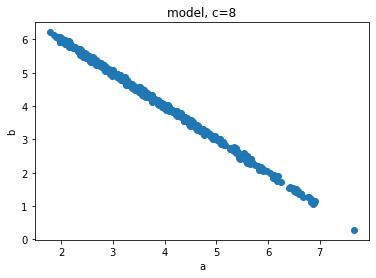

loss @ 0 250.71470138430595
loss @ 100 3.117312505841255
loss @ 200 3.277569353580475
loss @ 300 3.5031027495861053
loss @ 400 3.143440827727318
loss @ 500 3.4361781179904938
loss @ 600 4.702840209007263
loss @ 700 3.5631328523159027
loss @ 800 3.4223235845565796
loss @ 900 4.317334949970245
loss @ 1000 3.368438959121704
loss @ 1100 3.639338791370392
loss @ 1200 3.490132749080658
loss @ 1300 3.6164398193359375
loss @ 1400 3.7447198778390884
loss @ 1500 3.664977729320526
loss @ 1600 3.711328446865082
loss @ 1700 2.9395033717155457
loss @ 1800 2.911517709493637
loss @ 1900 4.034462422132492
loss @ 2000 3.2350163757801056
loss @ 2100 3.22176393866539
loss @ 2200 3.7901001572608948
loss @ 2300 3.569801688194275
loss @ 2400 3.53984272480011
loss @ 2500 3.877595603466034
loss @ 2600 3.6226391196250916
loss @ 2700 3.0730143785476685
loss @ 2800 4.214185759425163
loss @ 2900 4.09279590845108
loss @ 3000 2.8848781287670135
loss @ 3100 3.6986447870731354
loss @ 3200 3.696568265557289
loss @ 3300

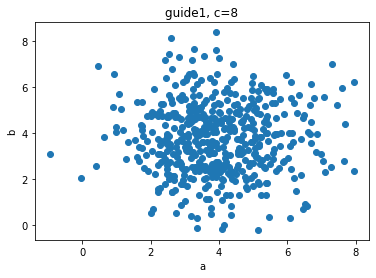

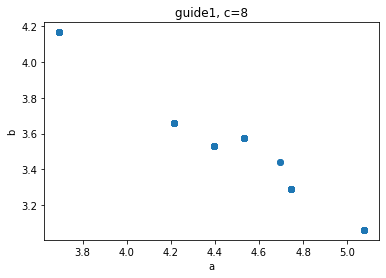

loss @ 0 8.555339336395264
loss @ 100 2.8156961649656296
loss @ 200 2.2635313272476196
loss @ 300 1.6999256238341331
loss @ 400 1.7192393466830254
loss @ 500 0.8920402228832245
loss @ 600 2.0527062863111496
loss @ 700 1.6825758069753647
loss @ 800 1.5520349852740765
loss @ 900 0.6633819621056318
loss @ 1000 0.7295918613672256
loss @ 1100 1.4210494253784418
loss @ 1200 0.5824477821588516
loss @ 1300 0.9634631061926484
loss @ 1400 0.11392593197524548
loss @ 1500 0.7322158059105277
loss @ 1600 0.8808927405625582
loss @ 1700 0.36768842302262783
loss @ 1800 0.3520975885912776
loss @ 1900 0.2855470413342118
loss @ 2000 0.638368712272495
loss @ 2100 0.39767273515462875
loss @ 2200 0.4885918339714408
loss @ 2300 0.2895228546112776
loss @ 2400 0.1077836265321821
loss @ 2500 -0.11635717377066612
loss @ 2600 0.5826993677765131
loss @ 2700 0.4942687153816223
loss @ 2800 -0.1473335511982441
loss @ 2900 0.20383371133357286
loss @ 3000 0.2701549082994461
loss @ 3100 0.2581884413957596
loss @ 3200 -0.

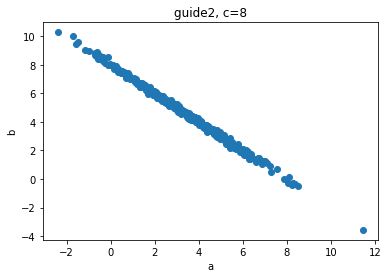

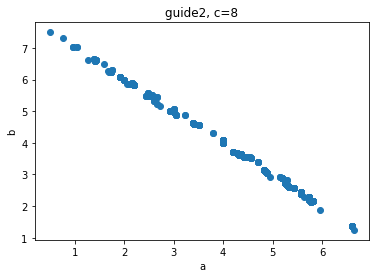

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyro
import torch
import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.optim
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO, MCMC, NUTS

def make_plot(x, y, main):
    plt.plot(x, y, "o")
    plt.title(main)
    plt.xlabel("a")
    plt.ylabel("b")
    plt.show()
    
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list, 0)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)
    
g1_nnb_c = simpleNN()
g1_nna_c = simpleNN()
g2_nnb_c = simpleNN()
g2_nna_c = simpleNN(input_size=2)

guide1_a = []
guide1_b = []
guide2_a = []
guide2_b = []
    
def model(observations={"c" : 0}):
    a = pyro.sample("a", dist.Normal(0, 2))
    b = pyro.sample("b", dist.Normal(0, 2))
    c = pyro.sample("c", dist.Normal(a + b, 0.05), obs=observations["c"])
    return c
    #return {"a" : a, "b" : b, "c" : c}

def guide1(observations={"c" : 0}):
    pyro.module("g1_nnb_c", g1_nnb_c)
    pyro.module("g1_nna_c", g1_nna_c)
    c = observations["c"]
    b_mu, b_sig = g1_nnb_c([c])
    b = pyro.sample("b", dist.Normal(b_mu, b_sig))
    a_mu, a_sig = g1_nna_c([c])
    a = pyro.sample("a", dist.Normal(a_mu, a_sig))
#     guide1_a.append(a.detach().numpy())
#     guide1_b.append(b.detach().numpy())
    return a.detach().numpy(), b.detach().numpy()

def guide2(observations={"c" : 0}):
    pyro.module("g2_nnb_c", g2_nnb_c)
    pyro.module("g2_nna_c", g2_nna_c)
    c = observations["c"]
    b_mu, b_sig = g2_nnb_c([c])
    b = pyro.sample("b", dist.Normal(b_mu, b_sig))
    a_mu, a_sig = g2_nna_c([c, b])
    a = pyro.sample("a", dist.Normal(a_mu, a_sig))
#     guide2_a.append(a.detach().numpy())
#     guide2_b.append(b.detach().numpy())
    return a.detach().numpy(), b.detach().numpy()
    
c = torch.tensor(8.)
num_samples = 500

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=num_samples)
mcmc.run({"c": c})
model_samples = mcmc.get_samples()
model_a = model_samples["a"].detach().numpy()
model_b = model_samples["b"].detach().numpy()
make_plot(model_a, model_b, main="model, c="+str(int(c)))

def run_guide_csis(guide):
    pyro.clear_param_store()
    g1_nnb_c = simpleNN()
    g1_nna_c = simpleNN()
    g2_nnb_c = simpleNN()
    g2_nna_c = simpleNN(input_size=2)
    adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
    optimizer = Adam(adam_params)
    n_steps = 5000
    csis = pyro.infer.CSIS(model, guide, optimizer, num_inference_samples=100)

    for step in range(n_steps):
        loss = csis.step()
        if step % 100 == 0:
            print("loss @ " + str(step), loss)
    posterior = csis.run(observations={"c": c})
    marginal = pyro.infer.EmpiricalMarginal(posterior, ["a", "b"])
    csis_samples_a = []
    csis_samples_b = []
    for _ in range(num_samples):
        sample = marginal()
        a = float(sample[0])
        b = float(sample[1])
        csis_samples_a.append(a)
        csis_samples_b.append(b)
    return csis_samples_a, csis_samples_b

guide1_a_is, guide1_b_is = run_guide_csis(guide1)
for _ in range(num_samples):
    a, b =guide1({"c" : c})
    guide1_a.append(a)
    guide1_b.append(b)
make_plot(guide1_a, guide1_b, main="guide1, c="+str(int(c)))
make_plot(guide1_a_is, guide1_b_is, main="guide1, c="+str(int(c)))

guide2_a_is, guide2_b_is = run_guide_csis(guide2)
for _ in range(num_samples):
    a, b =guide2({"c" : c})
    guide2_a.append(a)
    guide2_b.append(b)
make_plot(guide2_a, guide2_b, main="guide2, c="+str(int(c)))
make_plot(guide2_a_is, guide2_b_is, main="guide2, c="+str(int(c)))


def run_guide_svi(guide):
    pyro.clear_param_store()
    g1_nnb_c = simpleNN()
    g1_nna_c = simpleNN()
    g2_nnb_c = simpleNN()
    g2_nna_c = simpleNN(input_size=2)
    adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
    optimizer = Adam(adam_params)
    n_steps = 5000
    guide_a = []
    guide_b = []
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    for step in range(n_steps):
        loss = svi.step({"c" : c})
        if step % 100 == 0:
            print("loss @ " + str(step), loss)
    for _ in range(num_samples):
        a, b =guide({"c" : c})
        guide_a.append(a)
        guide_b.append(b)
    return guide_a, guide_b
# guide1_a, guide1_b = run_guide_svi(guide1)
# make_plot(guide1_a, guide1_b, main="guide1")
# guide2_a, guide2_b = run_guide_svi(guide2)
# make_plot(guide2_a, guide2_b, main="guide2")
